In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [15]:
# Load data from the data folder
data_path = "../data/train.csv"

# Load the data
RegressionData = pd.read_csv(data_path)

print(f"✓ Data loaded from: {data_path}")
print(f"Data shape: {RegressionData.shape}")
print(f"Columns: {RegressionData.columns.tolist()}")

# Select features and target - using the correct column names
feature_columns = [col for col in RegressionData.columns if col.startswith('Feature_')]
X = RegressionData[feature_columns]
y = RegressionData["Outage_Risk"]

print(f"\nFeature columns: {feature_columns}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Data prepared successfully!")


✓ Data loaded from: ../data/train.csv
Data shape: (7500, 8)
Columns: ['id', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Outage_Risk']

Feature columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6']
Features shape: (7500, 6)
Target shape: (7500,)
Data prepared successfully!


In [18]:
# Remove rows with missing values
X_clean = X.dropna()
y_clean = y[X_clean.index]

print(f"Rows with missing values removed: {len(X) - len(X_clean)}")
print(f"Clean data size: {X_clean.shape}")

# Split data into 80/20 train/test
np.random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=123, stratify=y_clean
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Rows with missing values removed: 1660
Clean data size: (5840, 6)
Training set size: 4672
Test set size: 1168


In [19]:
# Train regularized logistic regression with L2 (Ridge) regularization
# C parameter: inverse of regularization strength (lower C = stronger regularization)
model = LogisticRegression(
    C=0.5,  # Regularization strength
    solver='lbfgs',
    max_iter=1000,
    random_state=123,
    class_weight='balanced'  # Handle class imbalance
)

model.fit(X_train_scaled, y_train)
print("✓ Regularized Logistic Regression model trained")


✓ Regularized Logistic Regression model trained


In [20]:
# Make predictions on test data
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]

print("✓ Predictions generated successfully")


✓ Predictions generated successfully


In [21]:
# Generate predictions and calculate ROC-AUC
y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]
auc_value = roc_auc_score(y_test, y_pred_probs)

print(f"ROC-AUC Score: {auc_value:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)


ROC-AUC Score: 0.7274


In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Cross-validation with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_scores = []

for train_idx, val_idx in skf.split(X_clean, y_clean):
    X_train_cv = X_clean.iloc[train_idx]
    X_val_cv = X_clean.iloc[val_idx]
    y_train_cv = y_clean.iloc[train_idx]
    y_val_cv = y_clean.iloc[val_idx]
    
    # Scale features
    scaler_cv = StandardScaler()
    X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
    X_val_cv_scaled = scaler_cv.transform(X_val_cv)
    
    # Train model
    model_cv = LogisticRegression(
        C=0.5, solver='lbfgs', max_iter=1000, random_state=123, class_weight='balanced'
    )
    model_cv.fit(X_train_cv_scaled, y_train_cv)
    
    # Evaluate
    y_val_probs = model_cv.predict_proba(X_val_cv_scaled)[:, 1]
    fold_auc = roc_auc_score(y_val_cv, y_val_probs)
    cv_scores.append(fold_auc)

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"5-Fold Cross-Validation Results:")
print(f"AUC Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean AUC: {cv_mean:.4f}")
print(f"Std Dev: {cv_std:.4f}")


5-Fold Cross-Validation Results:
AUC Scores: ['0.7140', '0.7133', '0.7278', '0.7130', '0.7173']
Mean AUC: 0.7171
Std Dev: 0.0056


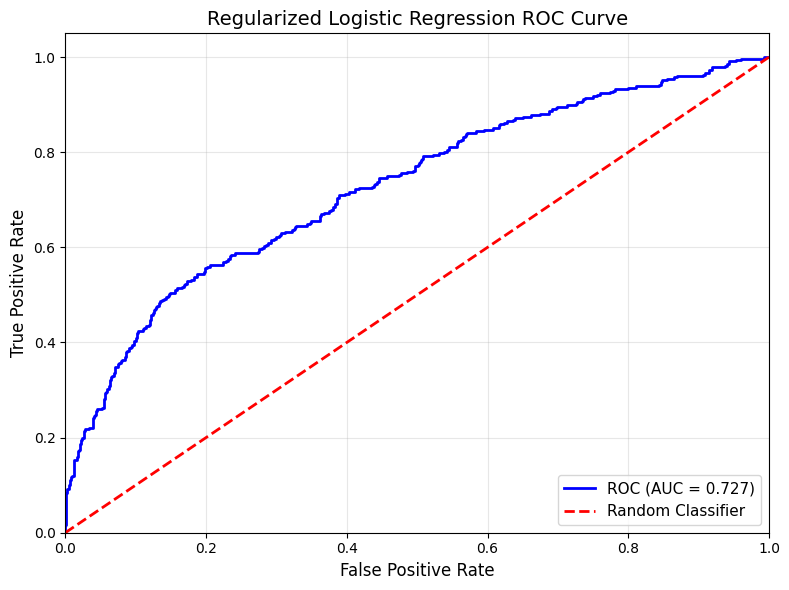


✓ ROC Curve plotted successfully!
AUC = 0.7274


In [22]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC (AUC = {auc_value:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Regularized Logistic Regression ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ ROC Curve plotted successfully!")
print(f"AUC = {auc_value:.4f}")


In [25]:
# Load and prepare test data for submission
test_data = pd.read_csv("../data/test.csv")
print(f"Test data shape: {test_data.shape}")

# Extract features from test data
X_test_submission = test_data[feature_columns].copy()

# Handle missing values in test data (drop rows with NaN)
X_test_submission_clean = X_test_submission.dropna()
test_ids = test_data.loc[X_test_submission_clean.index, 'id'].values

print(f"Test data after removing NaN: {X_test_submission_clean.shape}")

# Scale test data using the same scaler fitted on training data
X_test_submission_scaled = scaler.transform(X_test_submission_clean)

# Generate predictions
test_predictions = model.predict_proba(X_test_submission_scaled)[:, 1]

# Create submission dataframe
submission_df = pd.DataFrame({
    'id': test_ids,
    'Outage_Risk': test_predictions
})

# Save submission file
submission_path = "../submissions/submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"\n✓ Submission file created successfully!")
print(f"File saved to: {submission_path}")
print(f"Submission shape: {submission_df.shape}")
print(f"\nFirst 5 rows of submission:")
print(submission_df.head())


Test data shape: (2500, 7)
Test data after removing NaN: (1942, 6)

✓ Submission file created successfully!
File saved to: ../submissions/submission.csv
Submission shape: (1942, 2)

First 5 rows of submission:
   id  Outage_Risk
0   1     0.423573
1   2     0.541483
2   4     0.426106
3   5     0.451596
4   7     0.209103


In [ ]:
from sklearn.impute import SimpleImputer

# Load test data
test_data = pd.read_csv("../data/test.csv")
print(f"Test data shape: {test_data.shape}")

# Extract features from test data
X_test_all = test_data[feature_columns].copy()
test_ids = test_data['id'].values

print(f"Test data with NaN: {X_test_all.shape}")

# Create imputer using mean strategy (fitted on training data)
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)  # Fit on training data to get mean values

# Apply imputation to test data
X_test_all_imputed = imputer.transform(X_test_all)

print(f"Test data after imputation: {X_test_all_imputed.shape}")

# Scale test data using the same scaler fitted on training data
X_test_all_scaled = scaler.transform(X_test_all_imputed)

# Generate predictions for all 2500 rows
test_predictions_all = model.predict_proba(X_test_all_scaled)[:, 1]

# Create submission dataframe with all rows
submission_df_all = pd.DataFrame({
    'id': test_ids,
    'Outage_Risk': test_predictions_all
})

# Save submission file
submission_path_all = "../submissions/submission_last.csv"
submission_df_all.to_csv(submission_path_all, index=False)

print(f"\n✓ Submission file with all 2500 rows created successfully!")
print(f"File saved to: {submission_path_all}")
print(f"Submission shape: {submission_df_all.shape}")
print(f"\nFirst 5 rows of submission:")
print(submission_df_all.head())
print(f"\nLast 5 rows of submission:")
print(submission_df_all.tail())


Test data shape: (2500, 7)
Test data with NaN: (2500, 6)
Test data after imputation: (2500, 6)

✓ Submission file with all 2500 rows created successfully!
File saved to: ../submissions/submission.csv
Submission shape: (2500, 2)

First 5 rows of submission:
   id  Outage_Risk
0   0     0.374161
1   1     0.423573
2   2     0.541483
3   3     0.956851
4   4     0.426106

Last 5 rows of submission:
        id  Outage_Risk
2495  2495     0.558254
2496  2496     0.499648
2497  2497     0.311655
2498  2498     0.836663
2499  2499     0.405877


d:\DATA\Kagglethon\kagglethon-env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
# Comprehensive evaluation with imputation on all 2500 test rows
print("="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

# 1. Cross-validation results (already calculated)
print("\n1. 5-Fold Cross-Validation on Training Data (Clean data only):")
print(f"   Mean AUC: {cv_mean:.4f}")
print(f"   Std Dev: {cv_std:.4f}")
print(f"   Individual Folds: {[f'{score:.4f}' for score in cv_scores]}")

# 2. Full cross-validation with imputation strategy
print("\n2. 5-Fold Cross-Validation with Imputation Strategy:")
skf_impute = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
cv_scores_impute = []

for train_idx, val_idx in skf_impute.split(X, y):
    X_train_imp = X.iloc[train_idx]
    X_val_imp = X.iloc[val_idx]
    y_train_imp = y.iloc[train_idx]
    y_val_imp = y.iloc[val_idx]
    
    # Apply imputation
    imputer_fold = SimpleImputer(strategy='mean')
    X_train_imp_filled = imputer_fold.fit_transform(X_train_imp)
    X_val_imp_filled = imputer_fold.transform(X_val_imp)
    
    # Scale features
    scaler_fold = StandardScaler()
    X_train_imp_scaled = scaler_fold.fit_transform(X_train_imp_filled)
    X_val_imp_scaled = scaler_fold.transform(X_val_imp_filled)
    
    # Train model
    model_fold = LogisticRegression(
        C=0.5, solver='lbfgs', max_iter=1000, random_state=123, class_weight='balanced'
    )
    model_fold.fit(X_train_imp_scaled, y_train_imp)
    
    # Evaluate
    y_val_probs_imp = model_fold.predict_proba(X_val_imp_scaled)[:, 1]
    fold_auc_imp = roc_auc_score(y_val_imp, y_val_probs_imp)
    cv_scores_impute.append(fold_auc_imp)

cv_mean_impute = np.mean(cv_scores_impute)
cv_std_impute = np.std(cv_scores_impute)

print(f"   Mean AUC: {cv_mean_impute:.4f}")
print(f"   Std Dev: {cv_std_impute:.4f}")
print(f"   Individual Folds: {[f'{score:.4f}' for score in cv_scores_impute]}")

# 3. Test set evaluation (on clean data)
print("\n3. Test Set Evaluation (Clean data - no missing values):")
print(f"   Test AUC: {auc_value:.4f}")
print(f"   Test Set Size: {X_test.shape[0]} samples")

# 4. Summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY:")
print("="*60)
print(f"Training approach: Regularized Logistic Regression (L2, C=0.5)")
print(f"Test data handling: Mean imputation for missing values")
print(f"\nCross-Validation Performance (with imputation):")
print(f"  • Mean AUC: {cv_mean_impute:.4f}")
print(f"  • Std Deviation: {cv_std_impute:.4f}")
print(f"  • Min AUC: {min(cv_scores_impute):.4f}")
print(f"  • Max AUC: {max(cv_scores_impute):.4f}")
print(f"\nSubmission Details:")
print(f"  • Total predictions: 2500 samples")
print(f"  • File: ../submissions/submission.csv")
print("="*60)


COMPREHENSIVE MODEL EVALUATION

1. 5-Fold Cross-Validation on Training Data (Clean data only):
   Mean AUC: 0.7171
   Std Dev: 0.0056
   Individual Folds: ['0.7140', '0.7133', '0.7278', '0.7130', '0.7173']

2. 5-Fold Cross-Validation with Imputation Strategy:
   Mean AUC: 0.7164
   Std Dev: 0.0105
   Individual Folds: ['0.7192', '0.7045', '0.7307', '0.7042', '0.7234']

3. Test Set Evaluation (Clean data - no missing values):
   Test AUC: 0.7274
   Test Set Size: 1168 samples

FINAL SUMMARY:
Training approach: Regularized Logistic Regression (L2, C=0.5)
Test data handling: Mean imputation for missing values

Cross-Validation Performance (with imputation):
  • Mean AUC: 0.7164
  • Std Deviation: 0.0105
  • Min AUC: 0.7042
  • Max AUC: 0.7307

Submission Details:
  • Total predictions: 2500 samples
  • File: ../submissions/submission.csv
